# Functional scores
In this notebook, we look at both human and yeast functional scores in the dataset

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import requests

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

out_path = Path("functional_scores")
out_path.mkdir(exist_ok=True)

In [2]:
base_path = Path("../data/raw")
proc_path = Path("../data/processed")

# Phospho pair data
ptm_df_path = proc_path /"pdb_pairs" / "filtered_df.csv"
ptm_df = pd.read_csv(ptm_df_path)

# SIFTS data linking PDB chains to UniProt IDs
sifts_path = base_path / "sifts" / "pdb_chain_uniprot.csv"
sifts_df = pd.read_csv(sifts_path,low_memory=False)

# Human functional scores
scores_path = base_path / "functional_scores" / "functional_scores.xlsx"
scores_df = pd.read_excel(scores_path)

# Yeast functional scores
yeast_scores_path = base_path / "functional_scores" / "yeast_functional_score.csv"
yeast_scores_df = pd.read_csv(yeast_scores_path, low_memory=False)

# Human phosphosites

In [3]:
unique_ptm_prots = set(ptm_df["UNIPROT"])
unique_func_prots = set(scores_df["uniprot"])
intersection = set.intersection(unique_ptm_prots, unique_func_prots)
print(f"Found {len(intersection)} proteins with human functional scores")

Found 100 proteins with human functional scores


In [4]:
# Keep only proteins within the intersection
filt_ptm_df = ptm_df.loc[ptm_df["UNIPROT"].isin(intersection)]

In [5]:
filt_ptm_df

,UNIPROT,UNIPROT_RESIDUE_NUMBER,ENTRY_ID_ONE,AUTH_ASYM_ID_ONE,STRUCT_ASYM_ID_ONE,AUTH_SEQ_ID_ONE,PDB_SEQ_ID_ONE,CHEM_COMP_ONE,ENTRY_ID_TWO,AUTH_ASYM_ID_TWO,...,AUTH_SEQ_ID_TWO,PDB_SEQ_ID_TWO,CHEM_COMP_TWO,AUTH_FULL_ONE,AUTH_FULL_TWO,RENAMED_ASYM_ID_ONE,RENAMED_ASYM_ID_TWO,RENAMED_ENTITY_ONE,RENAMED_ENTITY_TWO,PHOSPHOSITE
0,P24941,160,2r3p,A,A,160.0,161,THR,5nev,C,...,160.0,165,TPO,2r3p_A,5nev_C,A,C,2r3p_A,5nev_C,P24941_160
1,P24941,160,2r3p,A,A,160.0,161,THR,2g9x,A,...,160.0,161,TPO,2r3p_A,2g9x_A,A,A,2r3p_A,2g9x_A,P24941_160
2,P24941,160,2r3p,A,A,160.0,161,THR,2wma,A,...,160.0,165,TPO,2r3p_A,2wma_A,A,A,2r3p_A,2wma_A,P24941_160
3,P24941,160,2r3p,A,A,160.0,161,THR,2uzb,A,...,160.0,160,TPO,2r3p_A,2uzb_A,A,A,2r3p_A,2uzb_A,P24941_160
4,P28482,187,4qp4,A,A,187.0,196,TYR,6opg,A,...,185.0,181,PTR,4qp4_A,6opg_A,A,A,4qp4_A,6opg_A,P28482_187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135109,P48730,220,3uyt,B,B,220.0,222,THR,6f1w,A,...,220.0,240,TPO,3uyt_B,6f1w_A,B,A,3uyt_B,6f1w_A,P48730_220
135110,P0CG47,217,5ulk,B,B,65.0,65,SER,4wzp,A,...,65.0,65,SEP,5ulk_B,4wzp_A,B,A,5ulk_B,4wzp_A,P0CG47_217
135111,P0CG47,217,5ulk,B,B,65.0,65,SER,5n2w,B,...,65.0,65,SEP,5ulk_B,5n2w_B,B,B,5ulk_B,5n2w_B,P0CG47_217
135120,P24941,160,3qx2,A,A,160.0,168,THR,3bhv,C,...,160.0,162,TPO,3qx2_A,3bhv_C,A,C,3qx2_A,3bhv_C,P24941_160


In [6]:
set1 = set(filt_ptm_df["ENTRY_ID_ONE"].unique())
set2 = set(filt_ptm_df["ENTRY_ID_TWO"].unique())
all_pdb_ids = set.union(set1,set2)
print(f"Found {len(all_pdb_ids)} unique PDB IDs within the intersection")

Found 2932 unique PDB IDs within the intersection


In [7]:
mapper = {"uniprot":"UNIPROT", "position":"UNIPROT_RESIDUE_NUMBER"}
scores_df = scores_df.rename(mapper=mapper,axis=1)

In [8]:
scores_dict = {}
not_found = []

for idx, row in filt_ptm_df.iterrows():
    uniprot_id = row["UNIPROT"]
    residue = row["UNIPROT_RESIDUE_NUMBER"]
    combined = f"{uniprot_id}_{residue}"
    if (combined not in scores_dict.keys()) and (combined not in not_found) :
        match = scores_df.loc[(scores_df["UNIPROT"]==uniprot_id) & (scores_df["UNIPROT_RESIDUE_NUMBER"]==residue)]
        if len(match) == 1:
            score = float(match["functional_score"])
            scores_dict[combined] = score
        else:
            not_found.append(combined)

In [9]:
print(f"Number of phosphosites found: {len(scores_dict)}")
print(f"Number of phosphosites not found: {len(not_found)}")

Number of phosphosites found: 77
Number of phosphosites not found: 85


In [10]:
human_scores_df = pd.DataFrame.from_dict(scores_dict,orient='index',columns=["functional_score"])
human_scores_df["organism"] = "human"

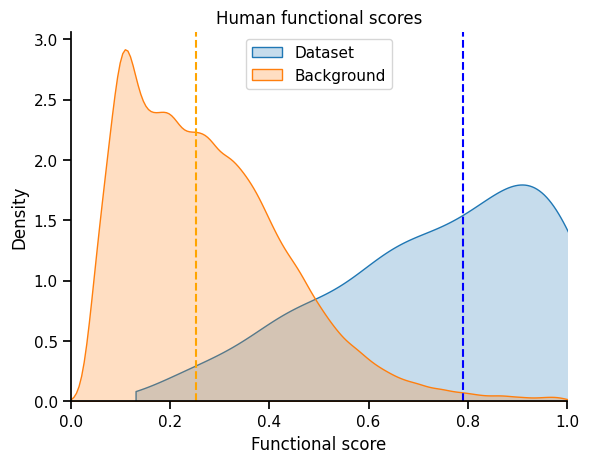

In [11]:
sns.set_context('notebook')
sns.kdeplot(scores_dict.values(),fill=True,label="Dataset",cut=1)
sns.kdeplot(scores_df["functional_score"],fill=True,label='Background',cut=1)

plt.xlabel("Functional score")

plt.axvline(np.median(list(scores_dict.values())),ls='--',color='blue')
plt.axvline(np.median(scores_df["functional_score"]), ls="--",color='orange')

plt.xlim(0,1)

plt.title("Human functional scores")
plt.legend(loc='upper center')
sns.despine()

plt.savefig(out_path / "human_functional_score_pairs.png",dpi=120,bbox_inches='tight')

# Yeast phosphosites

In [12]:
# Map SGD IDs to UniProt IDs
id_conversion_df = pd.read_csv("../data/raw/functional_scores/gProfiler_scerevisiae.csv")

sgd_to_uniprot = {}

for idx, row in id_conversion_df.iterrows():
    sgd_id = row["initial_alias"]
    uniprot_id = row["converted_alias"]
    if uniprot_id != "None":
        sgd_to_uniprot[sgd_id] = uniprot_id
        
# Reverse the dict
uniprot_to_sgd = {v:k for k,v in sgd_to_uniprot.items()}



In [13]:
yeast_unique_func_prots_sgd = set(yeast_scores_df["acc"])

yeast_unique_func_prots = set()
not_found = set()
for sgd_id in yeast_unique_func_prots_sgd:
    try:
        yeast_unique_func_prots.add(sgd_to_uniprot[sgd_id])
    except KeyError:
        not_found.add(sgd_id)



In [14]:
yeast_intersection = set.intersection(unique_ptm_prots, yeast_unique_func_prots)
print(f"Found {len(yeast_intersection)} proteins with functional scores")

# Convert these proteins back to their original IDs
sgd_yeast_intersection = [uniprot_to_sgd[x] for x in yeast_intersection]
print(sgd_yeast_intersection)


Found 5 proteins with functional scores
['YBR223C', 'YBL016W', 'YNL088W', 'YEL056W', 'YDR001C']


In [15]:
subset_yeast_scores_df = yeast_scores_df.loc[yeast_scores_df["acc"].isin(sgd_yeast_intersection)]
# Add a column with the Uniprot IDs

uniprot_ids = [sgd_to_uniprot[x] for x in list(subset_yeast_scores_df["acc"])]
subset_yeast_scores_df["PROTEIN"] = uniprot_ids


/tmp/ipykernel_197151/220389130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_yeast_scores_df["PROTEIN"] = uniprot_ids


In [16]:
subset_yeast_scores_df["phosphosite"] = subset_yeast_scores_df["PROTEIN"] + "_" + subset_yeast_scores_df["position"].astype(str)

/tmp/ipykernel_197151/3341571092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_yeast_scores_df["phosphosite"] = subset_yeast_scores_df["PROTEIN"] + "_" + subset_yeast_scores_df["position"].astype(str)


In [18]:
yeast_ptm_df = ptm_df.loc[ptm_df["UNIPROT"].isin(yeast_intersection)]
yeast_ptm_df["phosphosite"] = yeast_ptm_df["UNIPROT"] + "_" + yeast_ptm_df["UNIPROT_RESIDUE_NUMBER"].astype(str)

/tmp/ipykernel_197151/1070638627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yeast_ptm_df["phosphosite"] = yeast_ptm_df["UNIPROT"] + "_" + yeast_ptm_df["UNIPROT_RESIDUE_NUMBER"].astype(str)


In [19]:
psite_idxs = []
found_psites = set()
for idx, row in yeast_ptm_df.iterrows():
    psite = row["phosphosite"]
    match = subset_yeast_scores_df.loc[subset_yeast_scores_df["phosphosite"]==psite]
    if not match.empty:
        psite_idxs.append(idx)
        found_psites.add(psite)

print(found_psites)

In [21]:
yeast_scores_in_data = subset_yeast_scores_df.loc[subset_yeast_scores_df["phosphosite"].isin(found_psites)]
yeast_scores_in_data["organism"] = "yeast"

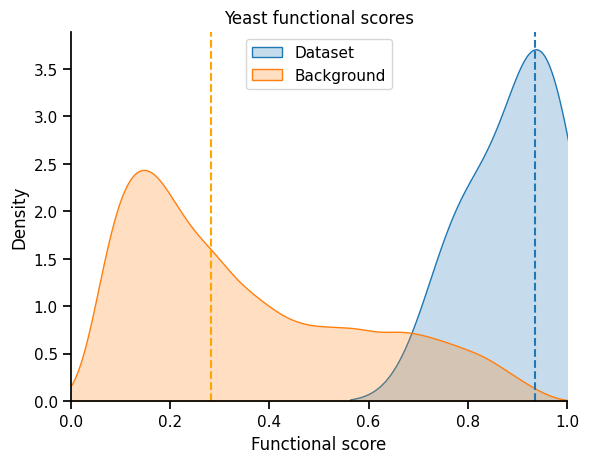

In [23]:
sns.kdeplot(yeast_scores_in_data["functional_score"],label="Dataset",fill=True)
sns.kdeplot(yeast_scores_df["functional_score"],label="Background",fill=True,cut=1)
plt.legend(loc="best")
sns.despine()

plt.xlim(0,1)

plt.axvline(yeast_scores_in_data["functional_score"].median(),ls='--')
plt.axvline(yeast_scores_df["functional_score"].median(),ls='--',color='orange')

plt.legend(loc='upper center')
plt.xlabel("Functional score")

plt.title("Yeast functional scores")

plt.savefig(out_path / "yeast_functional_scores.png",dpi=120,bbox_inches='tight')

In [24]:
human_scores_df

,functional_score,organism
P24941_160,0.883129,human
P28482_187,0.987901,human
P49841_216,0.860796,human
Q9NWZ3_342,0.544342,human
O14965_288,0.981411,human
...,...,...
Q07955_201,0.634719,human
P15056_729,0.785771,human
P78527_2609,0.444460,human
P78527_2638,0.368006,human


In [25]:
yeast_scores_df = yeast_scores_in_data.drop(["site","acc","position","PROTEIN"],axis=1)
yeast_scores_df = yeast_scores_df[["phosphosite","functional_score","organism"]]
yeast_scores_df = yeast_scores_df.reset_index()
yeast_scores_df.drop(["index"],axis=1,inplace=True)

In [26]:
yeast_scores_df

,phosphosite,functional_score,organism
0,P32356_60,0.960420,yeast
1,P32356_83,0.935694,yeast
2,P16892_182,0.787743,yeast


In [27]:
human_scores_df["phosphosite"] = list(human_scores_df.index)
human_scores_df = human_scores_df[["phosphosite","functional_score","organism"]]
human_scores_df = human_scores_df[["phosphosite","functional_score","organism"]]
human_scores_df = human_scores_df.reset_index()
human_scores_df.drop(["index"],axis=1,inplace=True)
final_df = pd.concat([human_scores_df,yeast_scores_df])
final_df.to_csv("functional_scores.csv",index=None)